In [1]:
!nvidia-smi

Fri May 20 02:50:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8    19W / 370W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torchmetrics

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import albumentations as A
import torchvision
import torchvision.transforms as transforms
import albumentations.pytorch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from torchmetrics.functional import jaccard_index

In [15]:
torch.__version__

'1.11.0+cu113'

## Data

In [16]:
label_path = "./PH2Dataset/clinical_diagnosis_labels.csv"
df = pd.read_csv(label_path)
subject_list = list(df["Name"])

In [17]:
def train_valid_test_split(folder, train_ratio, valid_ratio, test_ratio):
    
    normal_nevus = 0
    atypical_nevus = 0
    melanoma = 0
    
    train_files=[]
    valid_files=[]
    test_files=[]
    
    for file in folder:
        if normal_nevus <= 80:  
            if normal_nevus < 80*train_ratio:
                train_files.append(file)
            elif normal_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            normal_nevus += 1
            
        elif atypical_nevus <= 80:
            if atypical_nevus < 80*train_ratio:
                train_files.append(file)
            elif atypical_nevus < 80*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            atypical_nevus += 1
        
        else:
            if melanoma < 40*train_ratio:
                train_files.append(file)
            elif melanoma < 40*(train_ratio+valid_ratio):
                valid_files.append(file)
            else:
                test_files.append(file)
            melanoma += 1
            
    return train_files, valid_files, test_files

In [18]:
config = {
    "model": "unet",
    "image_height": 192,
    "image_width": 256,
    "initial_lr": 1e-4,
    "n_epochs": 50,
    "batch_size": 1
}

In [19]:
train_files, valid_files, test_files = train_valid_test_split(subject_list, 0.8, 0.1, 0.1)

In [20]:
print(len(train_files), len(valid_files), len(test_files))

160 20 20


In [21]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in train_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

64 64 32


In [22]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in valid_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [23]:
normal_nevus = 0
atypical_nevus = 0
melanoma = 0
for file in test_files:
    label = df.loc[df['Name']==file,['Clinical Diagnosis']]
    if (label == 0).bool():
        normal_nevus += 1
    elif (label == 1).bool():
        atypical_nevus += 1
    else:
        melanoma += 1
print(normal_nevus, atypical_nevus, melanoma)

8 8 4


In [24]:
train_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    A.augmentations.transforms.VerticalFlip(p=0.5),
    A.augmentations.geometric.rotate.Rotate(),
    A.pytorch.transforms.ToTensorV2(),
])

test_tfm = A.Compose([
    A.augmentations.geometric.resize.Resize(width=config["image_width"], height=config["image_height"]),
    A.pytorch.transforms.ToTensorV2(),
])

In [25]:
class PH2Dataset(Dataset):
    def __init__(self, file_list, transforms):
        self.dataset_path = "./PH2Dataset/PH2 Dataset images/"
        self.subject_list = file_list
        self.transforms = transforms
    
    def __len__(self):

        return len(self.subject_list)

    def __getitem__(self, idx):

        subject = self.subject_list[idx]
        
        img_folder = subject + "_Dermoscopic_Image"
        img_filename = subject + ".bmp"
        mask_folder =  subject + "_lesion"
        mask_filename =  mask_folder + ".bmp"
        
        image_path = os.path.join(self.dataset_path, subject, img_folder, img_filename)
        mask_path = os.path.join(self.dataset_path, subject, mask_folder, mask_filename)
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,0)
          

        if self.transforms is not None:
            
            masks = []
            masks.append(mask)
            transformed = self.transforms(image=image, masks = masks)
            image = transformed["image"] / 255  # [0, 255] (int) -> [0, 1] (float)
            mask = torch.tensor(transformed["masks"][0] / 255).unsqueeze(0).type(torch.float32)  # [H, W] (int) -> [1, H, W] (float) 
      
        return image, mask

In [26]:
train_set = PH2Dataset(train_files, transforms=train_tfm)
valid_set = PH2Dataset(valid_files, transforms=test_tfm)
test_set = PH2Dataset(test_files, transforms=test_tfm)

torch.Size([192, 256, 3])
tensor([[[0.2510, 0.1961, 0.1725],
         [0.2078, 0.1608, 0.1333],
         [0.2235, 0.1843, 0.1529],
         ...,
         [0.1882, 0.1647, 0.1373],
         [0.1569, 0.1255, 0.1020],
         [0.1765, 0.1529, 0.1373]],

        [[0.2235, 0.1843, 0.1725],
         [0.2275, 0.1804, 0.1765],
         [0.1882, 0.1333, 0.1333],
         ...,
         [0.1882, 0.1647, 0.1020],
         [0.1647, 0.1490, 0.1020],
         [0.1725, 0.1647, 0.1373]],

        [[0.2157, 0.1647, 0.1176],
         [0.2118, 0.1647, 0.1255],
         [0.2000, 0.1529, 0.1176],
         ...,
         [0.2118, 0.1804, 0.1529],
         [0.1961, 0.1529, 0.1333],
         [0.1647, 0.1294, 0.1255]],

        ...,

        [[0.1922, 0.1647, 0.1569],
         [0.2118, 0.1843, 0.1765],
         [0.2039, 0.1725, 0.1608],
         ...,
         [0.1569, 0.1373, 0.1098],
         [0.1922, 0.1765, 0.1529],
         [0.1647, 0.1529, 0.1294]],

        [[0.1961, 0.1804, 0.1529],
         [0.2000, 0.1

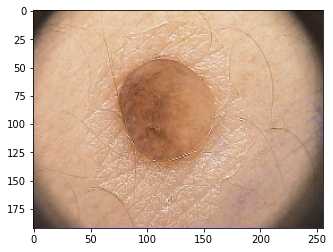

In [27]:
img = train_set[1][0].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

torch.Size([192, 256, 1])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])


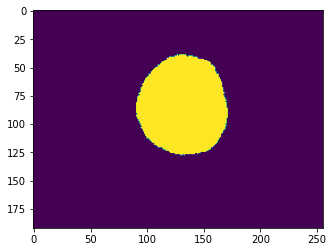

In [28]:
img = train_set[1][1].permute(1,2,0)
print(img.shape)
print(img)
plt.imshow(img)

## Model

In [29]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1e-6):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)  # smooth to prevent 0/0
        
        return 1 - IoU

In [30]:
class BCEplusIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1e-6):
        
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        
        IoU = (intersection + smooth) / (union + smooth)  # smooth to prevent 0/0
        
        BCELoss = nn.BCELoss()
        BCE = BCELoss(inputs, targets)
        
        return 1 - IoU + BCE

In [31]:
class doubleConv(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(inChannels, outChannels, 3),
            nn.ReLU(),
            nn.Conv2d(outChannels, outChannels, 3),
        )
        
    def forward(self, x):
        return self.double_conv(x)

In [32]:
class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        
        self.double_convs = nn.ModuleList(
            [doubleConv(channels[i], channels[i + 1])
                 for i in range(len(channels) - 1)])
        
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for double_conv in self.double_convs:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = double_conv(x)
            blockOutputs.append(x)
            x = self.pool(x)
       
        # return the list containing the intermediate outputs
        return blockOutputs

In [33]:
class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
       
        self.channels = channels
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                for i in range(len(channels) - 1)])
        self.double_convs = nn.ModuleList(
            [doubleConv(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)])
    
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            cropped_encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, cropped_encFeat], dim=1)
            x = self.double_convs[i](x)
        # return the final decoder output
        return x
    
    def crop(self, encFeat, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        cropped_encFeat = transforms.CenterCrop([H, W])(encFeat)
        # return the cropped features
        return cropped_encFeat

In [34]:
class UNet(nn.Module):
    def __init__(self, 
                 encChannels=(3, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True,
                 outSize=(config["image_height"], config["image_width"])):
        
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.outconv = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:]) # ::-1 means reversed order
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.outconv(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map

In [35]:
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config["batch_size"], shuffle=True, num_workers=0, pin_memory=True)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16)).to(device)

" change loss function "
loss_func = nn.BCEWithLogitsLoss()
# loss_func = IoULoss()
# loss_func = BCEplusIoULoss()

optimizer = torch.optim.Adam(model.parameters(), lr=config["initial_lr"])

train_steps = len(train_set) / config["batch_size"]
valid_steps = len(valid_set) / config["batch_size"]
test_steps = len(valid_set) / config["batch_size"]

In [52]:
print("Training the network...")
best_loss = float("inf")
train_loss_history = []
train_iou_history = []
valid_loss_history = []
valid_iou_history = []

for epoch in range(config["n_epochs"]):
  
    model.train()
    
    total_train_loss = 0
    total_train_iou = 0
    total_valid_loss = 0
    total_valid_iou = 0
    
    
    for (i, (x, y)) in enumerate(tqdm(train_loader)):
       
        (x, y) = (x.to(device), y.to(device))
        
        logits = model(x)
        pred = torch.sigmoid(logits)                
        loss = loss_func(logits, y)
        iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
        total_train_loss += loss
        total_train_iou += iou
        
        
        
  
    train_loss = total_train_loss / train_steps
    train_loss_history.append(train_loss.cpu().detach().numpy())
    train_iou = total_train_iou / train_steps
    train_iou_history.append(train_iou.cpu().detach().numpy())
    print(f'[ Train | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {train_loss:.5f} iou = {train_iou:.5f}')
    
   
    with torch.no_grad():
       
        model.eval()
       
        for (x, y) in tqdm(valid_loader):
           
            (x, y) = (x.to(device), y.to(device))
           
            logits = model(x)
            pred = torch.sigmoid(logits)
            loss = loss_func(logits, y)
            iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
        
            total_valid_loss += loss
            total_valid_iou += iou
            
        
    valid_loss = total_valid_loss / valid_steps
    valid_loss_history.append(valid_loss.cpu().detach().numpy())
    valid_iou = total_valid_iou / valid_steps
    valid_iou_history.append(valid_iou.cpu().detach().numpy())
    print(f'[ Valid | {epoch + 1:03d}/{config["n_epochs"]:03d} ] loss = {valid_loss:.5f} iou = {valid_iou:.5f}')
    
    # save models
    if valid_loss < best_loss:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                }, f'{config["model"]}_best.ckpt')

        best_loss = valid_loss

Training the network...


100%|██████████| 160/160 [00:02<00:00, 56.47it/s]


[ Train | 001/050 ] loss = 0.61051 iou = 0.29137


100%|██████████| 20/20 [00:00<00:00, 73.89it/s]


[ Valid | 001/050 ] loss = 0.63366 iou = 0.31339
Best model found at epoch 0, saving model


100%|██████████| 160/160 [00:02<00:00, 56.48it/s]


[ Train | 002/050 ] loss = 0.43059 iou = 0.60424


100%|██████████| 20/20 [00:00<00:00, 105.04it/s]

[ Valid | 002/050 ] loss = 0.55956 iou = 0.57082
Best model found at epoch 1, saving model



100%|██████████| 160/160 [00:02<00:00, 58.57it/s]


[ Train | 003/050 ] loss = 0.34668 iou = 0.70378


100%|██████████| 20/20 [00:00<00:00, 95.83it/s]


[ Valid | 003/050 ] loss = 0.50811 iou = 0.61346
Best model found at epoch 2, saving model


100%|██████████| 160/160 [00:03<00:00, 50.12it/s]


[ Train | 004/050 ] loss = 0.32003 iou = 0.70860


100%|██████████| 20/20 [00:00<00:00, 103.72it/s]


[ Valid | 004/050 ] loss = 0.44747 iou = 0.65475
Best model found at epoch 3, saving model


100%|██████████| 160/160 [00:02<00:00, 57.29it/s]


[ Train | 005/050 ] loss = 0.33286 iou = 0.69721


100%|██████████| 20/20 [00:00<00:00, 83.11it/s]


[ Valid | 005/050 ] loss = 0.48995 iou = 0.62532


100%|██████████| 160/160 [00:02<00:00, 54.78it/s]


[ Train | 006/050 ] loss = 0.32060 iou = 0.70385


100%|██████████| 20/20 [00:00<00:00, 75.06it/s]


[ Valid | 006/050 ] loss = 0.41286 iou = 0.66915
Best model found at epoch 5, saving model


100%|██████████| 160/160 [00:02<00:00, 57.74it/s]


[ Train | 007/050 ] loss = 0.31185 iou = 0.71366


100%|██████████| 20/20 [00:00<00:00, 75.92it/s]


[ Valid | 007/050 ] loss = 0.51492 iou = 0.62452


100%|██████████| 160/160 [00:02<00:00, 53.52it/s]


[ Train | 008/050 ] loss = 0.30670 iou = 0.71237


100%|██████████| 20/20 [00:00<00:00, 106.76it/s]


[ Valid | 008/050 ] loss = 0.59889 iou = 0.60862


100%|██████████| 160/160 [00:02<00:00, 62.16it/s]


[ Train | 009/050 ] loss = 0.30850 iou = 0.71640


100%|██████████| 20/20 [00:00<00:00, 53.80it/s]


[ Valid | 009/050 ] loss = 0.59655 iou = 0.61011


100%|██████████| 160/160 [00:02<00:00, 53.75it/s]


[ Train | 010/050 ] loss = 0.30058 iou = 0.70766


100%|██████████| 20/20 [00:00<00:00, 103.06it/s]


[ Valid | 010/050 ] loss = 0.46204 iou = 0.65955


100%|██████████| 160/160 [00:02<00:00, 58.20it/s]


[ Train | 011/050 ] loss = 0.31988 iou = 0.70143


100%|██████████| 20/20 [00:00<00:00, 80.52it/s]


[ Valid | 011/050 ] loss = 0.61341 iou = 0.60330


100%|██████████| 160/160 [00:02<00:00, 58.00it/s]


[ Train | 012/050 ] loss = 0.29881 iou = 0.71291


100%|██████████| 20/20 [00:00<00:00, 99.84it/s] 


[ Valid | 012/050 ] loss = 0.41928 iou = 0.67860


100%|██████████| 160/160 [00:02<00:00, 56.54it/s]


[ Train | 013/050 ] loss = 0.30637 iou = 0.71679


100%|██████████| 20/20 [00:00<00:00, 88.53it/s]


[ Valid | 013/050 ] loss = 0.46938 iou = 0.65545


100%|██████████| 160/160 [00:02<00:00, 53.37it/s]


[ Train | 014/050 ] loss = 0.29090 iou = 0.71583


100%|██████████| 20/20 [00:00<00:00, 143.02it/s]


[ Valid | 014/050 ] loss = 0.37509 iou = 0.69692
Best model found at epoch 13, saving model


100%|██████████| 160/160 [00:02<00:00, 61.53it/s]


[ Train | 015/050 ] loss = 0.30155 iou = 0.71373


100%|██████████| 20/20 [00:00<00:00, 85.86it/s] 


[ Valid | 015/050 ] loss = 0.42932 iou = 0.67479


100%|██████████| 160/160 [00:03<00:00, 53.13it/s]


[ Train | 016/050 ] loss = 0.31083 iou = 0.70748


100%|██████████| 20/20 [00:00<00:00, 86.99it/s]


[ Valid | 016/050 ] loss = 0.49133 iou = 0.65756


100%|██████████| 160/160 [00:02<00:00, 55.71it/s]


[ Train | 017/050 ] loss = 0.28990 iou = 0.71548


100%|██████████| 20/20 [00:00<00:00, 82.57it/s]


[ Valid | 017/050 ] loss = 0.46087 iou = 0.66133


100%|██████████| 160/160 [00:02<00:00, 55.42it/s]


[ Train | 018/050 ] loss = 0.30145 iou = 0.71022


100%|██████████| 20/20 [00:00<00:00, 76.67it/s]


[ Valid | 018/050 ] loss = 0.46555 iou = 0.67405


100%|██████████| 160/160 [00:02<00:00, 56.27it/s]


[ Train | 019/050 ] loss = 0.28886 iou = 0.72304


100%|██████████| 20/20 [00:00<00:00, 58.11it/s]


[ Valid | 019/050 ] loss = 0.47822 iou = 0.66612


100%|██████████| 160/160 [00:02<00:00, 54.94it/s]


[ Train | 020/050 ] loss = 0.29052 iou = 0.71522


100%|██████████| 20/20 [00:00<00:00, 100.69it/s]


[ Valid | 020/050 ] loss = 0.36301 iou = 0.70873
Best model found at epoch 19, saving model


100%|██████████| 160/160 [00:02<00:00, 53.77it/s]


[ Train | 021/050 ] loss = 0.30345 iou = 0.72431


100%|██████████| 20/20 [00:00<00:00, 89.78it/s]


[ Valid | 021/050 ] loss = 0.51927 iou = 0.65523


100%|██████████| 160/160 [00:02<00:00, 53.88it/s]


[ Train | 022/050 ] loss = 0.29232 iou = 0.71910


100%|██████████| 20/20 [00:00<00:00, 101.34it/s]


[ Valid | 022/050 ] loss = 0.47154 iou = 0.67280


100%|██████████| 160/160 [00:02<00:00, 60.26it/s]


[ Train | 023/050 ] loss = 0.29366 iou = 0.73113


100%|██████████| 20/20 [00:00<00:00, 71.47it/s]


[ Valid | 023/050 ] loss = 0.41062 iou = 0.68939


100%|██████████| 160/160 [00:02<00:00, 56.55it/s]


[ Train | 024/050 ] loss = 0.29408 iou = 0.71724


100%|██████████| 20/20 [00:00<00:00, 105.83it/s]


[ Valid | 024/050 ] loss = 0.44835 iou = 0.67132


100%|██████████| 160/160 [00:03<00:00, 52.25it/s]


[ Train | 025/050 ] loss = 0.27926 iou = 0.72756


100%|██████████| 20/20 [00:00<00:00, 71.83it/s]


[ Valid | 025/050 ] loss = 0.45880 iou = 0.69462


100%|██████████| 160/160 [00:02<00:00, 59.95it/s]


[ Train | 026/050 ] loss = 0.28480 iou = 0.72474


100%|██████████| 20/20 [00:00<00:00, 94.97it/s]


[ Valid | 026/050 ] loss = 0.41808 iou = 0.69765


100%|██████████| 160/160 [00:02<00:00, 57.59it/s]


[ Train | 027/050 ] loss = 0.29239 iou = 0.71436


100%|██████████| 20/20 [00:00<00:00, 69.15it/s]


[ Valid | 027/050 ] loss = 0.45116 iou = 0.67909


100%|██████████| 160/160 [00:02<00:00, 55.77it/s]


[ Train | 028/050 ] loss = 0.27361 iou = 0.72566


100%|██████████| 20/20 [00:00<00:00, 78.57it/s]


[ Valid | 028/050 ] loss = 0.32551 iou = 0.73216
Best model found at epoch 27, saving model


100%|██████████| 160/160 [00:02<00:00, 55.28it/s]


[ Train | 029/050 ] loss = 0.27250 iou = 0.73654


100%|██████████| 20/20 [00:00<00:00, 110.34it/s]


[ Valid | 029/050 ] loss = 0.37102 iou = 0.71543


100%|██████████| 160/160 [00:02<00:00, 54.68it/s]


[ Train | 030/050 ] loss = 0.27858 iou = 0.72791


100%|██████████| 20/20 [00:00<00:00, 82.66it/s]


[ Valid | 030/050 ] loss = 0.55836 iou = 0.63639


100%|██████████| 160/160 [00:02<00:00, 55.28it/s]


[ Train | 031/050 ] loss = 0.28337 iou = 0.71357


100%|██████████| 20/20 [00:00<00:00, 89.08it/s]


[ Valid | 031/050 ] loss = 0.33793 iou = 0.72986


100%|██████████| 160/160 [00:02<00:00, 58.02it/s]


[ Train | 032/050 ] loss = 0.28265 iou = 0.72832


100%|██████████| 20/20 [00:00<00:00, 68.87it/s]


[ Valid | 032/050 ] loss = 0.34947 iou = 0.72469


100%|██████████| 160/160 [00:03<00:00, 50.42it/s]


[ Train | 033/050 ] loss = 0.28168 iou = 0.72275


100%|██████████| 20/20 [00:00<00:00, 112.63it/s]


[ Valid | 033/050 ] loss = 0.40003 iou = 0.71033


100%|██████████| 160/160 [00:02<00:00, 55.70it/s]


[ Train | 034/050 ] loss = 0.27919 iou = 0.72311


100%|██████████| 20/20 [00:00<00:00, 80.70it/s]


[ Valid | 034/050 ] loss = 0.36323 iou = 0.72626


100%|██████████| 160/160 [00:02<00:00, 57.23it/s]


[ Train | 035/050 ] loss = 0.28372 iou = 0.72159


100%|██████████| 20/20 [00:00<00:00, 78.07it/s]


[ Valid | 035/050 ] loss = 0.41737 iou = 0.70964


100%|██████████| 160/160 [00:02<00:00, 61.74it/s]


[ Train | 036/050 ] loss = 0.27466 iou = 0.73505


100%|██████████| 20/20 [00:00<00:00, 79.40it/s]


[ Valid | 036/050 ] loss = 0.46261 iou = 0.69175


100%|██████████| 160/160 [00:02<00:00, 53.61it/s]


[ Train | 037/050 ] loss = 0.28093 iou = 0.72570


100%|██████████| 20/20 [00:00<00:00, 130.05it/s]


[ Valid | 037/050 ] loss = 0.32647 iou = 0.73951


100%|██████████| 160/160 [00:02<00:00, 57.70it/s]


[ Train | 038/050 ] loss = 0.29042 iou = 0.72467


100%|██████████| 20/20 [00:00<00:00, 91.24it/s]


[ Valid | 038/050 ] loss = 0.36778 iou = 0.71746


100%|██████████| 160/160 [00:02<00:00, 57.96it/s]


[ Train | 039/050 ] loss = 0.28425 iou = 0.71887


100%|██████████| 20/20 [00:00<00:00, 93.16it/s]


[ Valid | 039/050 ] loss = 0.37510 iou = 0.72010


100%|██████████| 160/160 [00:02<00:00, 54.63it/s]


[ Train | 040/050 ] loss = 0.28013 iou = 0.72900


100%|██████████| 20/20 [00:00<00:00, 98.62it/s]


[ Valid | 040/050 ] loss = 0.40833 iou = 0.70550


100%|██████████| 160/160 [00:02<00:00, 57.36it/s]


[ Train | 041/050 ] loss = 0.29556 iou = 0.72515


100%|██████████| 20/20 [00:00<00:00, 91.66it/s] 


[ Valid | 041/050 ] loss = 0.41594 iou = 0.70023


100%|██████████| 160/160 [00:02<00:00, 56.92it/s]


[ Train | 042/050 ] loss = 0.26941 iou = 0.73024


100%|██████████| 20/20 [00:00<00:00, 59.25it/s]


[ Valid | 042/050 ] loss = 0.45038 iou = 0.69823


100%|██████████| 160/160 [00:02<00:00, 55.88it/s]


[ Train | 043/050 ] loss = 0.27358 iou = 0.72495


100%|██████████| 20/20 [00:00<00:00, 110.41it/s]


[ Valid | 043/050 ] loss = 0.35587 iou = 0.72551


100%|██████████| 160/160 [00:03<00:00, 51.88it/s]


[ Train | 044/050 ] loss = 0.27175 iou = 0.73111


100%|██████████| 20/20 [00:00<00:00, 102.21it/s]


[ Valid | 044/050 ] loss = 0.31217 iou = 0.74553
Best model found at epoch 43, saving model


100%|██████████| 160/160 [00:02<00:00, 57.29it/s]


[ Train | 045/050 ] loss = 0.28953 iou = 0.72164


100%|██████████| 20/20 [00:00<00:00, 68.39it/s]


[ Valid | 045/050 ] loss = 0.47065 iou = 0.67678


100%|██████████| 160/160 [00:02<00:00, 58.00it/s]


[ Train | 046/050 ] loss = 0.27931 iou = 0.72639


100%|██████████| 20/20 [00:00<00:00, 129.34it/s]


[ Valid | 046/050 ] loss = 0.35128 iou = 0.72474


100%|██████████| 160/160 [00:02<00:00, 55.36it/s]


[ Train | 047/050 ] loss = 0.27115 iou = 0.72965


100%|██████████| 20/20 [00:00<00:00, 78.66it/s]


[ Valid | 047/050 ] loss = 0.43794 iou = 0.67509


100%|██████████| 160/160 [00:03<00:00, 53.19it/s]


[ Train | 048/050 ] loss = 0.27037 iou = 0.73166


100%|██████████| 20/20 [00:00<00:00, 90.57it/s]


[ Valid | 048/050 ] loss = 0.29158 iou = 0.75537
Best model found at epoch 47, saving model


100%|██████████| 160/160 [00:02<00:00, 58.89it/s]


[ Train | 049/050 ] loss = 0.28368 iou = 0.73032


100%|██████████| 20/20 [00:00<00:00, 60.38it/s]


[ Valid | 049/050 ] loss = 0.40111 iou = 0.71377


100%|██████████| 160/160 [00:02<00:00, 56.15it/s]


[ Train | 050/050 ] loss = 0.26526 iou = 0.73048


100%|██████████| 20/20 [00:00<00:00, 99.73it/s]

[ Valid | 050/050 ] loss = 0.35291 iou = 0.72629


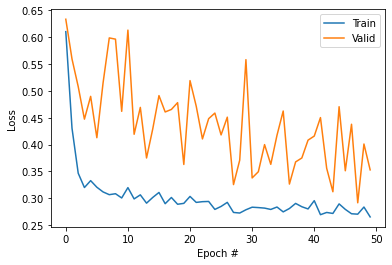

In [53]:
# plot the training loss
# plt.style.use("ggplot")
plt.figure()
plt.plot(train_loss_history, label="Train")
plt.plot(valid_loss_history, label="Valid")
# plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

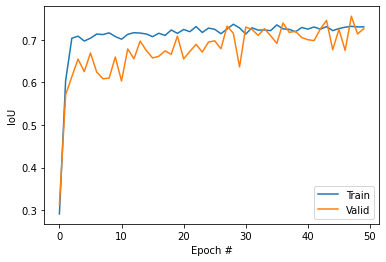

In [54]:
plt.figure()
plt.plot(train_iou_history, label="Train")
plt.plot(valid_iou_history, label="Valid")
# plt.title("Training IoU")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower right")
plt.show()

## Prediction

In [55]:
model_best = UNet(encChannels=(3, 16, 32, 64),decChannels=(64, 32, 16)).to(device)
checkpoint = torch.load(f'{config["model"]}_best.ckpt')
model_best.load_state_dict(checkpoint["model_state_dict"])
model_best.eval()
total_test_iou = 0

for (x, y) in tqdm(test_loader):
    
    (x, y) = (x.to(device), y.to(device))
 
    logits = model_best(x)
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, y.type(torch.int8), num_classes=2)
    total_test_iou += iou
    
test_iou = total_test_iou / test_steps
print("Test IoU:", test_iou)

100%|██████████| 20/20 [00:00<00:00, 70.95it/s]

Test IoU: tensor(0.7951, device='cuda:0')


In [56]:
def visualization(originImage, originMask, predMask, iou):
   
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    
    ax[0].imshow(originImage)
    ax[1].imshow(originMask)
    ax[2].imshow(predMask)
    
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    t = ax[2].text(170, 20, f'IoU = {iou:.3f}')
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='white'))
  
    figure.tight_layout()
    figure.show()

<Figure size 720x576 with 0 Axes>

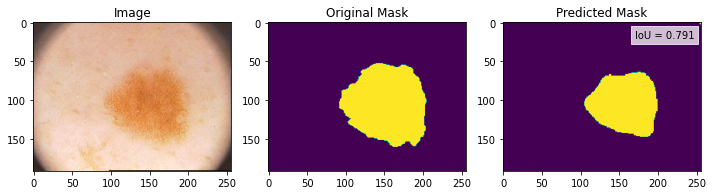

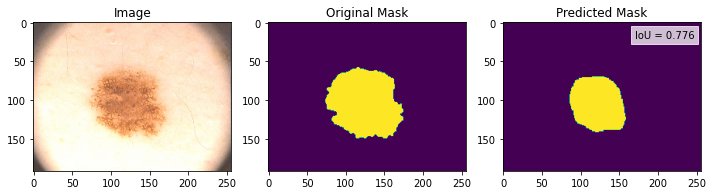

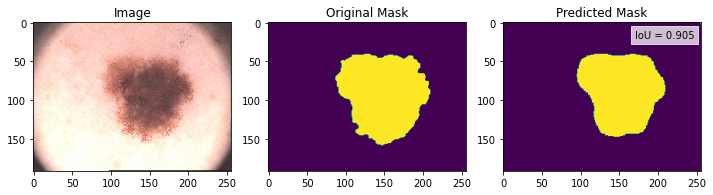

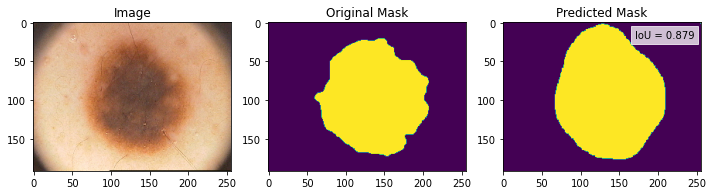

In [57]:
threshold = 0.5
fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

for i in range(4):
    img, mask = test_set[i]
    (img, mask) = (img.to(device), mask.to(device))

    logits = model_best(img.unsqueeze(0))
    pred = torch.sigmoid(logits)
    iou = jaccard_index(pred, mask.type(torch.int8), num_classes=2)
    pred_mask = (pred > threshold).float()*1

    origin_img = img.permute(1,2,0).cpu().detach().numpy()
    origin_mask = mask.permute(1,2,0).cpu().detach().numpy()
    pred_mask = pred_mask.squeeze(0).permute(1,2,0).cpu().detach().numpy()
    
    
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    
    visualization(origin_img, origin_mask, pred_mask, iou)